In [1]:
%pip install scikit-optimize
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
'''Imports'''
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from utils import encode
import seaborn as sns

from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, f1_score


In [3]:
'''Configure Utilities'''
np.set_printoptions(suppress=True, precision=5)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [4]:
'''Load Data'''
common_crs = "EPSG:4269"
coastline_shp = './geoData/califorina_pacific_coast-shapefile/3853-s3_2002_s3_reg_pacific_ocean.shp'
places_shp = './geoData/ca_places/CA_Places.shp'
counties_shp = './geoData/us_county/tl_2023_us_county.shp'
# counties_shp = './geoData/ca_counties/CA_Counties.shp'


coastline = gpd.read_file(coastline_shp)
places = gpd.read_file(places_shp)
counties = gpd.read_file(counties_shp)

rawData = fetch_california_housing(as_frame=True)
cal_housing_geo = gpd.GeoDataFrame(rawData.data, geometry=gpd.points_from_xy(rawData.data.Longitude, rawData.data.Latitude), crs=common_crs)
cal_housing_geo['y'] = rawData.target

In [5]:
'''Standardize Cordinate Projection'''
coastline = coastline.to_crs(common_crs)
places = places.to_crs(common_crs)
counties = counties.to_crs(common_crs)

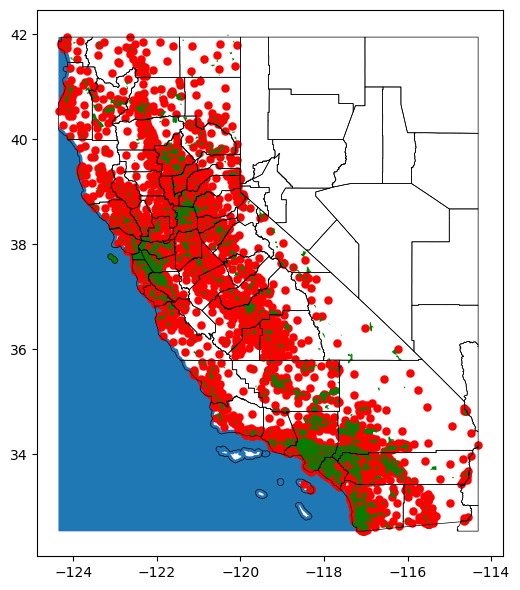

In [6]:
'''Set geo bounding box and plot'''
# print(cal_housing_geo.total_bounds)
housing_bounds = cal_housing_geo.total_bounds
counties = counties.clip(housing_bounds)
coastline = coastline.clip(housing_bounds)
fig, ax = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)

coastline.plot(ax=ax, edgecolor='blue', linewidth=0.1)
counties.boundary.plot(ax=ax, edgecolor='black', linewidth=.5)
cal_housing_geo.plot(ax=ax, color='red', linewidth=0.1)
places.plot(ax=ax, color='green', linewidth=1.0)
plt.show()



In [7]:
'''Feature Engineer Distance from Coast'''
house_to_coast = gpd.sjoin_nearest(cal_housing_geo, coastline, how="left", distance_col="meters")
cal_housing_geo['m_to_coast'] = house_to_coast['meters']

/opt/anaconda3/lib/python3.12/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [8]:
'''Feature Engineer Distance from Census Designated Place'''
house_to_interest = gpd.sjoin_nearest(cal_housing_geo, places, how="left", distance_col="meters")
# cal_housing_geo['CDP'] = house_to_interest['NAME'] // The name of the CDP does not appear to impact model performance
cal_housing_geo['m_to_CDP'] = house_to_interest['meters']

/opt/anaconda3/lib/python3.12/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [9]:
'''Feature Engineer County Data'''
# This data point does not appear to impact model performance, but can be useful for EDA.
# house_to_county = gpd.sjoin_nearest(cal_housing_geo, counties, how="left")
# cal_housing_geo['county_name'] = house_to_county['NAME']

'Feature Engineer County Data'

In [10]:
'''EDA: Color code counties by target value'''
edaData = gpd.GeoDataFrame(rawData.data, geometry=gpd.points_from_xy(rawData.data.Longitude, rawData.data.Latitude), crs=common_crs)
edaData['y'] = rawData.target

house_to_county = gpd.sjoin_nearest(edaData, counties, how="left")
edaData['county_name'] = house_to_county['NAME']


/opt/anaconda3/lib/python3.12/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [11]:
meanTarget = edaData.groupby('county_name')['y'].mean().reset_index()

print(meanTarget[meanTarget['county_name'] == 'Alameda']['y'][0])

2.085394595660749


In [41]:
'''Add Mean Target value to county data'''
meanTarget = edaData.groupby('county_name')['y'].mean().reset_index()

def setMeanTarget(row):
    value = meanTarget[meanTarget['county_name'] == row['NAME']]['y'].array
    row['mean_target'] = value[0] if len(value) else None
    return row

withTarget = counties.apply(setMeanTarget, axis=1)
withTarget.dropna(subset='mean_target')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,mean_target
2561,06,025,00277277,06025,0500000US06025,Imperial,Imperial County,06,H1,G4020,None,20940,None,A,10814568238,790135127,+33.0408143,-115.3554001,"POLYGON ((-114.72652 32.71827, -114.72706 32.7...",0.744051
2389,04,012,00043540,04012,0500000US04012,La Paz,La Paz County,06,H1,G4020,None,None,None,A,11646086556,36514346,+33.7276104,-114.0388060,"POLYGON ((-114.73122 33.30243, -114.73122 33.3...",0.875000
1625,06,065,00277297,06065,0500000US06065,Riverside,Riverside County,06,H1,G4020,348,40140,None,A,18671879658,242864215,+33.7298275,-116.0022389,"POLYGON ((-114.76650 33.43374, -114.76696 33.4...",1.401046
1108,06,071,00277300,06071,0500000US06071,San Bernardino,San Bernardino County,06,H1,G4020,348,40140,None,A,51976311343,96418184,+34.8566615,-116.1815707,"POLYGON ((-117.80254 33.97555, -117.80078 33.9...",1.267134
538,06,073,00277301,06073,0500000US06073,San Diego,San Diego County,06,H1,G4020,None,41740,None,A,10905039592,816542690,+33.0236041,-116.7761174,"POLYGON ((-117.61108 33.33399, -117.61104 33.3...",1.966821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,06,089,01682610,06089,0500000US06089,Shasta,Shasta County,06,H1,G4020,454,39820,None,A,9778891285,185818272,+40.7605142,-122.0435558,"POLYGON ((-121.32288 40.58492, -121.32288 40.5...",0.907653
120,32,013,00863310,32013,0500000US32013,Humboldt,Humboldt County,06,H1,G4020,None,49080,None,A,24969535383,44194899,+41.4079136,-118.1275915,"POLYGON ((-119.33142 41.03905, -119.33142 41.0...",0.887929
2979,06,093,00277311,06093,0500000US06093,Siskiyou,Siskiyou County,06,H1,G4020,None,None,None,A,16261931187,179151859,+41.5879861,-122.5332868,"POLYGON ((-123.71917 41.59561, -123.71900 41.5...",0.682054
1809,06,049,00277289,06049,0500000US06049,Modoc,Modoc County,06,H1,G4020,None,None,None,A,10225876984,660504011,+41.5929185,-120.7183704,"POLYGON ((-121.45721 41.94994, -121.45649 41.9...",0.511625


Text(0.5, 1.0, 'Median Home Value')

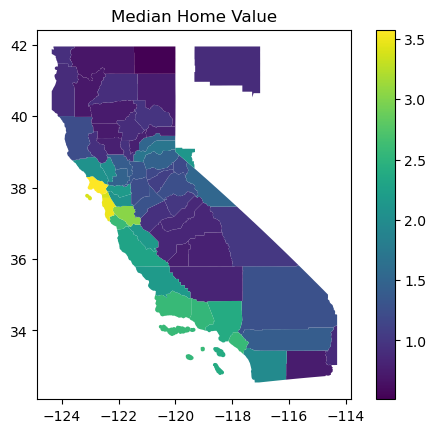

In [48]:
withTarget.plot(column='mean_target', legend=True)
plt.title('Median Home Value')

In [13]:
# cal_housing_geo = encode(cal_housing_geo, ['CDP','county_name'])

In [14]:
# cal_housing_geo.head()

In [15]:
modelData = cal_housing_geo.drop(columns=['y', 'geometry'])
X_train, X_test, y_train, y_test = train_test_split(modelData, rawData.target, test_size=0.3, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),('regress',RandomForestRegressor())], verbose=True)
predicted = pipe.fit(X_train, y_train).predict(X_test)


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing regress, total=   7.8s


In [16]:
mse = mean_squared_error(y_test, predicted)
print(mse)

0.21983824541510522


<Axes: title={'center': 'Feature Importances'}>

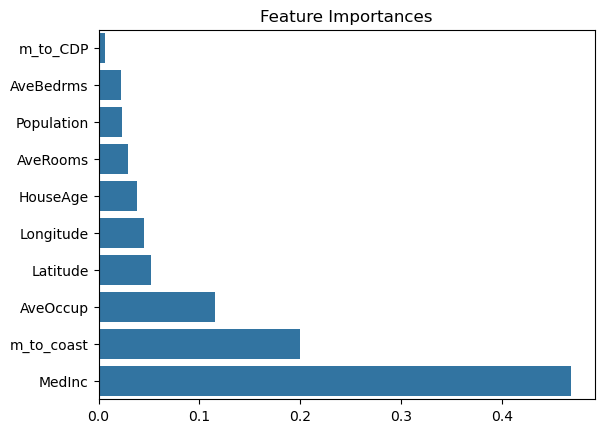

In [ ]:
regressor = pipe.steps[-1][-1]

feat_importance = list(zip(modelData.columns,regressor.feature_importances_))
feat_importance = sorted(feat_importance, key=lambda tup: tup[1])

feat=[x for x,y in feat_importance]
importance=[y for x,y in feat_importance]


plt.title('Feature Importances')
sns.barplot(y=feat, x=importance)